# Base ResNet-50 Evaluation

In [1]:
# %pip install nbformat

In [2]:
# %run data_preprocessing.ipynb

In [3]:
import os
import sys
import glob
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Hide warning logs from tensorflow
tf.get_logger().setLevel("ERROR")

In [4]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 300
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 5
tf.random.set_seed(5)
dataset_dir = "../datasets"

# Change dataset_dir when run in google colab 
if 'google.colab' in sys.modules:
    from google.colab import drive

    drive.mount('/content/drive')
    dataset_dir = "/content/drive/Othercomputers/Big Mac/datasets"
    BATCH_SIZE = 430

physical_gpus = tf.config.list_physical_devices('GPU')
print("Using available GPUs: ", physical_gpus)

tf.keras.mixed_precision.set_global_policy('float32')

Using available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Load ImageNet2012 dataset
def prepare_input_data(input):
    image = tf.cast(input['image'], tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)
    label = input['label']
    return image, label

def make_dataset(ds):
    return (
        ds.map(prepare_input_data, num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )


(train, validation, test), info = tfds.load(
    'imagenet2012_subset/10pct',
    split=['train', 'validation[:50%]', 'validation[50%:]'],
    shuffle_files=False,
    with_info=True,
    data_dir=dataset_dir
)

num_classes = info.features['label'].num_classes
class_names = info.features['label'].names

print(f"Train count: {info.splits['train'].num_examples}")
print(f"Validation count: {info.splits['validation[:50%]'].num_examples}")
print(f"Test count: {info.splits['validation[50%:]'].num_examples}")

train_dataset = make_dataset(train)
validation_dataset = make_dataset(validation)
test_dataset = make_dataset(test)

Train count: 128116
Validation count: 25000
Test count: 25000


In [6]:
# Load ResNet50 model

base_model = ResNet50(
    include_top=True,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

# Compile model
base_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
    ]
)


In [7]:
# Load adversarial data

def _parse_image(proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    image_f16 = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float16)
    label = parsed_features['label']
    image_f32 = tf.cast(image_f16, tf.float32)
    image_f32.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return image_f32, label


# Get all test tfrec files
file_paths = glob.glob(f'{dataset_dir}/adversaries/imagenet2012_subset/test-*.tfrec')
print(f"Found {len(file_paths)} TFrecord files")

# Create a TFRecordDataset from the list of file paths
raw_dataset = tf.data.TFRecordDataset(file_paths,  compression_type='GZIP')
adv_test_dataset = raw_dataset.map(_parse_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Found 59 TFrecord files


In [ ]:
# Collection of metrics

print("Evaluating training accuracy...\n")
train_metrics = base_model.evaluate(train_dataset, batch_size=BATCH_SIZE ,verbose=1)

print("Evaluating adversarial accuracy...\n")
adv_metrics = base_model.evaluate(adv_test_dataset, batch_size=BATCH_SIZE, verbose=1)

print("Evaluating standard accuracy...\n")
test_metrics = base_model.evaluate(test_dataset,batch_size=BATCH_SIZE, verbose=1)

Evaluating training accuracy...



## Baseline ResNet-50 metrics

In [ ]:
# Extract and analyze metrics

metric_names = ['loss', 'accuracy', 'top_5_accuracy']

# Unpack metrics directly from the evaluation results
train_loss, train_acc, train_top5 = train_metrics
test_loss, test_acc, test_top5 = test_metrics
adv_loss, adv_acc, adv_top5 = adv_metrics

# --- METRIC CALCULATIONS ---
# Generalization Gap: Difference between training and test accuracy.
generalization_gap = train_acc - test_acc

# Robustness/Transferability Gap: Difference between accuracy on clean and adversarial data.
robustness_gap = test_acc - adv_acc

print("# Standard Accuracy")
print(f"Top 1 Accuracy: {test_acc*100:.2f}%")
print(f"Top 5  Accuracy: {test_top5*100:.2f}%")
print(f"Loss: {test_loss*100:.2f}%\n")

print("# Generalization")
print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Generalization Gap: {generalization_gap*100:.2f}%\n")

print("# Robustness & Transferability")
print(f"Standard Accuracy: {test_acc*100:.2f}%")
print(f"Adversarial Accuracy: {adv_acc*100:.2f}%")
print(f"Robustness (Transferability) Gap: {robustness_gap*100:.2f}%\n")


# Standard Accuracy
Top 1 Accuracy: 70.47%
Top 5  Accuracy: 89.91%
Loss: 125.52%

# Generalization
Training Accuracy: 81.35%
Test Accuracy: 70.47%
Generalization Gap: 10.88%

# Robustness & Transferability
Standard Accuracy: 70.47%
Adversarial Accuracy: 64.53%
Robustness (Transferability) Gap: 5.94%



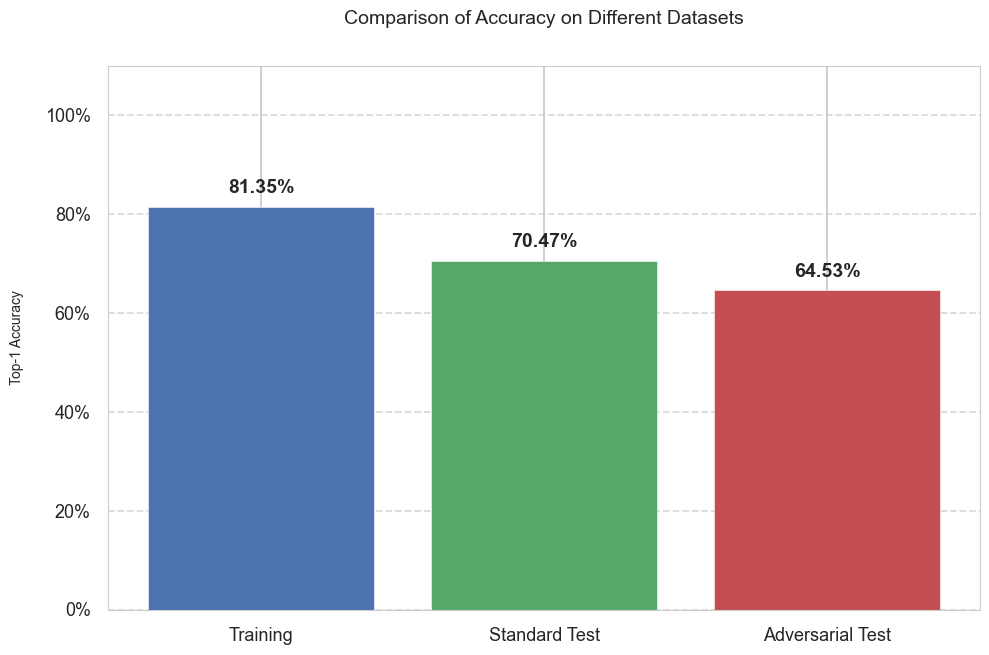

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns


sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-talk')

accuracies = [train_acc, test_acc, adv_acc]
labels = ['Training', 'Standard Test', 'Adversarial Test']
colors = ['#4c72b0', '#55a868', '#c44e52']

# Create Plot
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(labels, accuracies, color=colors, zorder=2)

# Add Annotations & Labels
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02,
            f'{yval:.2%}', # Format as percentage
            ha='center', va='bottom', fontsize=14, fontweight='bold')

# Set a clear title and subtitle
ax.set_title('Comparison of Accuracy on Different Datasets', fontsize=14, pad=30)

# Set y-axis label and limits
ax.set_ylabel('Top-1 Accuracy', fontsize=10, labelpad=15)
ax.set_ylim(0, 1.1)

# Format the y-axis to show percentages directly
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

# Add a light horizontal grid for easier value reading
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent labels from being cut off
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import requests # To make HTTP requests
import json     # To parse JSON data

class_names = info.features['label'].names
top_misclassified_classes = []


def get_imagenet_labels():
    """
    Fetches the 1000 ImageNet class labels from a trusted online source.
    Returns a list of class names or None if fetching fails.
    """
    print("Fetching ImageNet labels from URL...")
    url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        # The JSON is a dictionary like: {"0": ["n01440764", "tench"], ...}
        class_data = response.json()
        class_names = [class_data[str(i)][1] for i in range(len(class_data))]

        print("Labels fetched successfully.")
        return class_names
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching labels: {e}")
        print("Please check your internet connection and the URL.")
        return None

def plot_top_k_misclassified_cm(base_model, test_dataset, class_names, k=10, verbose=True):
    """
    Plots a confusion matrix heatmap restricted to the top-k most misclassified classes.
    Args:
    base_model: Trained Keras model.
    test_dataset: tf.data.Dataset yielding (x, y) batches.
    class_names: List of class names (index-aligned with labels).
    k: Number of most misclassified classes to plot.
    verbose: If True, prints metrics and details about selected classes.
    """
    num_classes = len(class_names)

    # Collect ground-truth labels and predictions
    if verbose:
        print("Manual Evaluation & Confusion Matrix")

    y_true = np.concatenate([y.numpy() if hasattr(y, "numpy") else y for _, y in test_dataset], axis=0)
    y_pred_proba = base_model.predict(test_dataset, verbose=0)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)

    # Overall metrics (macro-averaged)
    if verbose:
        print("\n Overall Performance Metrics ")
        report_dict = classification_report(y_true, y_pred_classes, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']
        print(f"Precision: {macro_avg['precision']:.4f}")
        print(f"Recall:    {macro_avg['recall']:.4f}")
        print(f"F1-Score:  {macro_avg['f1-score']:.4f}")

        try:
            auc_score = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
            print(f"Macro-Averaged AUC (One-vs-Rest): {auc_score:.4f}")
        except Exception as e:
            print(f"AUC could not be computed: {e}")

    # Confusion matrix over full class set
    labels = np.arange(num_classes)
    cm = confusion_matrix(y_true, y_pred_classes, labels=labels)

    # Misclassification counts per class (actual row total minus correct diagonal)
    row_totals = cm.sum(axis=1)
    correct = np.diag(cm)
    miscls_counts = row_totals - correct

    # Select top-k classes by misclassification count (descending)
    k = min(k, num_classes)
    top_idx = np.argsort(miscls_counts)[-k:][::-1]
    selected_class_names = [class_names[i] for i in top_idx]
    cm_top = cm[np.ix_(top_idx, top_idx)]

    if verbose:
        print(f"\n Confusion Matrix (Top {k} Most Misclassified Classes)")
        print("Top misclassified classes (by count):")
        
        for i in top_idx:
            total_i = row_totals[i]
            acc_i = (correct[i] / total_i) if total_i > 0 else 0.0
            print(f"Class: {class_names[i]:<30s} | Misclassified: {misclassification_counts[i]:<4} | Accuracy: {accuracy:.1%}")
            print(f"{i:4d} {class_names[i]:30s} miscls={miscls_counts[i]} "
                f"total={total_i} acc={acc_i:.2f}")

    # Plot the reduced confusion matrix
    plt.figure(figsize=(1.0 + 0.8 * k, 1.0 + 0.8 * k))
    sns.heatmap(
        cm_top,
        annot=True,
        fmt='d',
        cmap='Greens',
        xticklabels=selected_class_names,
        yticklabels=selected_class_names
    )
    plt.title(f'Confusion Matrix - Top {k} Most Misclassified Classes')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# c = get_imagenet_labels()
# plot_top_k_misclassified_cm(base_model, test_dataset, class_names=c, k=10, verbose=True)

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import requests # To make HTTP requests
import json     # To parse JSON data


def get_imagenet_labels():
    """
    Fetches the 1000 ImageNet class labels from a trusted online source.
    Returns a list of class names or None if fetching fails.
    """
    print("Fetching ImageNet labels from URL...")
    url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
    
    try:
        response = requests.get(url)
        # Raise an exception if the request was unsuccessful (e.g., 404 Not Found)
        response.raise_for_status()
        
        # The JSON is a dictionary like: {"0": ["n01440764", "tench"], ...}
        class_data = response.json()
        
        # Create an ordered list of class names from the dictionary
        class_names = [class_data[str(i)][1] for i in range(len(class_data))]
        
        print("Labels fetched successfully.")
        return class_names
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching labels: {e}")
        print("Please check your internet connection and the URL.")
        return None

class_names = get_imagenet_labels()
top_10_misclassified_class = []


def plot_top_10_misclassified_cm(base_model, test_dataset, class_names,top_k_class_names=[], k=10, verbose=True):
    """
    Plots a confusion matrix heatmap restricted to the top-k most misclassified classes.
    """
    # Check if class_names were loaded successfully
    if not class_names:
        print("Cannot generate plot without class names.")
        return
        
    num_classes = len(class_names)
    print(f"\nAnalyzing model performance across {num_classes} classes.")

    # --- 1. Collect ground-truth labels and predictions ---
    if verbose:
        print("Gathering predictions from the model...")
    y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
    y_pred_proba = base_model.predict(test_dataset, verbose=0)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)

    # --- 2. Calculate overall metrics (macro-averaged) ---
    if verbose:
        print("\n--- Overall Performance Metrics ---")
        # For brevity, we won't print the full report with 1000 class names
        report = classification_report(y_true, y_pred_classes, output_dict=True, zero_division=0)
        macro_avg = report['macro avg']
        print(f"Macro Precision: {macro_avg['precision']:.4f}")
        print(f"Macro Recall:    {macro_avg['recall']:.4f}")
        print(f"Macro F1-Score:  {macro_avg['f1-score']:.4f}")

    # --- 3. Identify top-k misclassified classes ---
    cm = confusion_matrix(y_true, y_pred_classes)
    misclassification_counts = cm.sum(axis=1) - np.diag(cm)
    
    top_k_indices = np.argsort(misclassification_counts)[-k:][::-1]
    
    cm_top_k = cm[np.ix_(top_k_indices, top_k_indices)]
    color_map = 'Greens'
    heatmap_title = 'Standard'
    if not len(top_k_class_names):
        top_k_class_names = [class_names[i] for i in top_k_indices]
        top_10_misclassified_class = top_k_class_names
    else:
        color_map = 'Reds'
        heatmap_title = 'Adversarial'

    if verbose:
        print(f"\n--- Top {k} Most Misclassified Classes ---")
        for i in top_k_indices:
            total_samples = cm.sum(axis=1)[i]
            accuracy = (np.diag(cm)[i] / total_samples) if total_samples > 0 else 0
            print(f"Class: {class_names[i]:<30s} | Misclassified: {misclassification_counts[i]:<4}/{total_samples} | Accuracy: {accuracy:.1%}")

    # --- 4. Plot the reduced confusion matrix ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm_top_k, annot=True, fmt='d', cmap=color_map,
        xticklabels=top_10_misclassified_class, yticklabels=top_10_misclassified_class
    )
    plt.title(f'{} Confusion Matrix: Top {k} Most Misclassified Classes', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()



plot_top_10_misclassified_cm(base_model, test_dataset, class_names, k=10)

plot_top_10_misclassified_cm(base_model, adv_test_dataset, class_names, k=10, top_k_class_names=top_10_misclassified_class)

Fetching ImageNet labels from URL...
Labels fetched successfully.

Analyzing model performance across 1000 classes.
Gathering predictions from the model...
